<span style="color:green">Exploration_01 인공지능과 가위 바위 보 하기</span>

목차
1. 데이터 준비
2. 딥러닝 네트워크 설계
3. 딥러닝 네트워크 학습
4. 테스트 데이터로 성능 확인
5. 모델 개선 방법
6. 회고

step 1. 데이터 준비
    
    - 사전에 teachablemachine.withgoogle.com을 통해서 학습 데이터로 사용될 가위, 바위, 보 사진 300장을 찍어둔다.
    - 준비된 학습 데이터 사진을 각 디렉토리에 업로드한다.
    - 업로드 된 데이터를 불러오고 Resize 과정을 거쳐준다.(사전에 준비한 이미지의 크기를 28x28로 변경해준다)
    - Resize 된 이미지를 가지고 load_data() 함수를 사용해서 라벨링을 해준다.
     * 주의사항 : 숫자의 경우는 0~9까지의 10개 클래스가 있지만 가위,바위,보의 경우 3개의 클래스를 가진다.
    

In [3]:
# 이미지를 Resize 해주는 과정

from PIL import Image
import glob
import os
import numpy as np

def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")
	target_size=(28,28) # 이미지의 크기를 28x28로 변경
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor" # 가위 이미지가 저장된 경로를 입력
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!


In [4]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)

print("주먹 이미지 resized 완료")

100  images to be resized.
100  images resized.
주먹 이미지 resized 완료


In [5]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

print("보 이미지 resized 완료")

100  images to be resized.
100  images resized.
보 이미지 resized 완료


In [6]:


def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수는 300장을 준비했기 때문에 300으로 입력
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화 -> 정규화 과정을 거치치 않으면 어떻게 되는가? / 작동하는가? 작동하지 않는가?

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  0


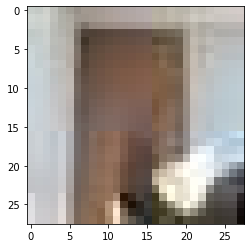

In [7]:
import matplotlib.pyplot as plt
plt.imshow(x_train[20])
print('라벨: ', y_train[20])

step 2. 딥러닝 네트워크 설계

    - 이번 모델은 tensorflow keras에서 Sequential API라는 방법을 사용함.
    - Sequential API방법은 개발의 자유도는 떨어지지만 매우 간단하게 딥러닝 모델을 만들 수 있음.
    

In [8]:
import tensorflow as tf
from tensorflow import keras

ch_1=16
ch_2=32
dense_1=32
# 추후 하이퍼파라미터를 변경해서 모델의 성능을 더 향상시킬 수 있다.

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(ch_1, (3,3), activation='relu', input_shape=(28,28,3))) 
model.add(keras.layers.MaxPool2D(2,2))                  # 흑백이미지의 경우 1, 칼라이미지의 경우 R,G,B 3값을 가지기 때문에 3으로 입력
model.add(keras.layers.Conv2D(ch_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(dense_1, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax')) # 우리는 3가지 클래스를 구분하기 때문에 3으로 입력

print('Model에 추가된 Layer 개수: ', len(model.layers))
model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_3 (Dense)              (

step 3. 딥러닝 네트워크 학습
    
    - 만든 네트워크의 입력은 (데이터갯수, 이미지크기 x, 이미지크기 y, 채널수)와 같은 형태를 가진다.
    - x_train 학습 데이터를 사용해서 딥러닝 네트워크를 학습시켜준다.
    - epochs=10이란 데이터를 10번 반복해서 학습을 시키라는 의미이다.
    - 우리는 x_train을 정규화시켰기 때문에 x_train_norm을 입력해주어야 한다.

In [9]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train_norm, y_train, epochs = 10) # 정규화된 x_train_norm 입력하기

Epoch 1/10
10/10 [==============================] - 27s 18ms/step - loss: 1.0933 - accuracy: 0.4033
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0805 - accuracy: 0.4200
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0541 - accuracy: 0.5467
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0128 - accuracy: 0.5833
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9448 - accuracy: 0.5900
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.8599 - accuracy: 0.6733
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.7747 - accuracy: 0.7333
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.7800
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 0.5824 - accuracy: 0.7967
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 0.5213 - accuracy: 0.8133


    * 인식 정확도가 0.4033부터 마지막에는 0.8133까지 상승하는 것을 확인할 수 있다.
    * 질문
        - 학습 데이터를 더 추가하면 인식 정확도를 더 향상 시킬 수 있는가?
        - 학습 데이터는 많으면 많을수록 정확도를 더 향상시켜주는가?
        - 하이퍼파라미터를 수정함으로써 인식 정확도를 더 향상 시킬 수 있는가?
        - 그렇다면 최적의 하이퍼파라미터 수치는 몇인가?
    

step 4. 테스트 데이터로 성능 확인
    
    - 위에서 학습시킨 모델을 가지고 테스트 데이터를 이용해서 성능을 확인해볼 수 있다.
    - 테스트 데이터도 학습 데이터와 같이 데이터를 디렉토리에 업로드 한 뒤 불러와서 이미지 사이즈를 변경하는 Resize 과정, 넘버링 과정을 거쳐준다.

In [10]:
image_dir_path_1 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
image_dir_path_2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
image_dir_path_3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path_1)
resize_images(image_dir_path_2)
resize_images(image_dir_path_3)

print("Test data 이미지 resize 완료!")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
Test data 이미지 resize 완료!


In [11]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 정규화 과정

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [12]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 1.6020 - accuracy: 0.3400
test_loss: 1.6020468473434448 
test_accuracy: 0.3400000035762787


    * 테스트 데이터 인식 정확도가 0.34로 학습 데이터 인식 정확도인 0.8167보다 많이 떨어지는 것을 확인할 수 있다.

setp 5. 모델 개선 방법
  
  - 하이퍼파라미터 변경을 통한 개선을 기대할 수 있다.
  - Conv2D레이어에서 입력 이미지의 턱징 수를 늘리거나 줄여보기
  - Dense 레이어에서 뉴런수를 바꿔보기
  - epoch를 변경해서 학습 반복 횟수 변경하기

In [13]:
#ch_1 을 32로 변경

import tensorflow as tf
from tensorflow import keras

ch_1=32
ch_2=32
dense_1=32
epoch_1 = 10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(ch_1, (3,3), activation='relu', input_shape=(28,28,3))) 
model.add(keras.layers.MaxPool2D(2,2))                  
model.add(keras.layers.Conv2D(ch_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(dense_1, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train_norm, y_train, epochs = epoch_1)

test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/10
10/10 [==============================] - 1s 11ms/step - loss: 1.0938 - accuracy: 0.3933
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0599 - accuracy: 0.5267
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0356 - accuracy: 0.5800
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9772 - accuracy: 0.5933
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.8937 - accuracy: 0.6533
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.7995 - accuracy: 0.7000
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.7667
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7800
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 0.5327 - accuracy: 0.7900
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 0.4424 - accuracy: 0.8233
10/10 - 0s - loss:

  - 첫번째 하이퍼파라미터 변경에서는 Conv2D 레이어에서 입력 이미지의 특징 수를 늘렸는데 정확도는 0.3167로 더 낮아졌다.

In [14]:
# dense의 값을 64로 설정

ch_1=16
ch_2=32
dense_1=64
epoch_1 = 10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(ch_1, (3,3), activation='relu', input_shape=(28,28,3))) 
model.add(keras.layers.MaxPool2D(2,2))                  
model.add(keras.layers.Conv2D(ch_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(dense_1, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train_norm, y_train, epochs = epoch_1)

test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/10
10/10 [==============================] - 0s 3ms/step - loss: 1.1484 - accuracy: 0.3233
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0949 - accuracy: 0.4167
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0674 - accuracy: 0.4067
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0248 - accuracy: 0.5733
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9935 - accuracy: 0.6133
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9184 - accuracy: 0.7067
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.8388 - accuracy: 0.6967
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.7419 - accuracy: 0.7300
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.7833
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.6733
10/10 - 0s - loss: 

  - 두번째 하이퍼파라미터 변경에서는 Dense의 값을 변경해서 뉴런수를 바꾸어보았지만 정확도는 0.3333으로 큰 변화가 없다.

In [24]:
# epoch 값을 20으로 설정

ch_1=16
ch_2=32
dense_1=32
epoch_1 = 20

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(ch_1, (3,3), activation='relu', input_shape=(28,28,3))) 
model.add(keras.layers.MaxPool2D(2,2))                  
model.add(keras.layers.Conv2D(ch_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(dense_1, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train_norm, y_train, epochs = epoch_1)

test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/20
10/10 [==============================] - 0s 3ms/step - loss: 1.0865 - accuracy: 0.4500
Epoch 2/20
10/10 [==============================] - 0s 3ms/step - loss: 1.0708 - accuracy: 0.3933
Epoch 3/20
10/10 [==============================] - 0s 3ms/step - loss: 1.0385 - accuracy: 0.5500
Epoch 4/20
10/10 [==============================] - 0s 3ms/step - loss: 0.9950 - accuracy: 0.6067
Epoch 5/20
10/10 [==============================] - 0s 3ms/step - loss: 0.9369 - accuracy: 0.6367
Epoch 6/20
10/10 [==============================] - 0s 3ms/step - loss: 0.8541 - accuracy: 0.6800
Epoch 7/20
10/10 [==============================] - 0s 3ms/step - loss: 0.7516 - accuracy: 0.7500
Epoch 8/20
10/10 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.7900
Epoch 9/20
10/10 [==============================] - 0s 3ms/step - loss: 0.5886 - accuracy: 0.7733
Epoch 10/20
10/10 [==============================] - 0s 3ms/step - loss: 0.5110 - accuracy: 0.8100
Epoch 11/20
10/10 [

  - 세번째 하이퍼파라미터 변경에서는 다른 값들을 초기 값으로 변경하고 학습반복횟수인 epoch 값을 20으로 변경했지만 큰 변화는 없었다.

### 데이터양 늘려서 모델 성능 개선

  - 먼저 사용했던 데이터 300개보다 더 많은 각각 600장씩 총 1800장의 데이터를 준비했다.

In [18]:
# 이미지 resize 작업

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor600/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock600/rock" # 가위 이미지가 저장된 경로를 입력
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper600/paper" # 가위 이미지가 저장된 경로를 입력
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

600  images to be resized.
600  images resized.
가위 이미지 resize 완료!
600  images to be resized.
600  images resized.
바위 이미지 resize 완료!
600  images to be resized.
600  images resized.
보 이미지 resize 완료!


In [53]:
from sklearn.model_selection import train_test_split

# 학습데이터와 평가데이터는 사이킷런을 이용해서 8:2 비율로 나누었다.

def load_data(img_path, number_of_data=1800): 
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor600/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock600/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper600/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x2, y2)=load_data(image_dir_path)
x2_norm = x2/255.0
x2_train, x2_test, y2_train, y2_test = train_test_split(x2_norm, y2, test_size=0.2, random_state=15)


print("x2_train shape: {}".format(x2_train.shape))
print("y2_train shape: {}".format(y2_train.shape))
print("X2_test shape: {}".format(x2_test.shape))
print("y2_test shape: {}".format(y2_test.shape))


학습데이터(x_train)의 이미지 개수는 1800 입니다.
x2_train shape: (1440, 28, 28, 3)
y2_train shape: (1440,)
X2_test shape: (360, 28, 28, 3)
y2_test shape: (360,)


In [54]:
ch_1=16
ch_2=32
dense_1=32
epoch_1=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(ch_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(ch_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(dense_1, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x2_train, y2_train, epochs=epoch_1)



Epoch 1/10
45/45 [==============================] - 0s 3ms/step - loss: 1.0415 - accuracy: 0.4563
Epoch 2/10
45/45 [==============================] - 0s 3ms/step - loss: 0.8199 - accuracy: 0.6347
Epoch 3/10
45/45 [==============================] - 0s 2ms/step - loss: 0.5835 - accuracy: 0.7917
Epoch 4/10
45/45 [==============================] - 0s 3ms/step - loss: 0.4400 - accuracy: 0.8417
Epoch 5/10
45/45 [==============================] - 0s 3ms/step - loss: 0.3085 - accuracy: 0.9049
Epoch 6/10
45/45 [==============================] - 0s 2ms/step - loss: 0.2304 - accuracy: 0.9264
Epoch 7/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1830 - accuracy: 0.9382
Epoch 8/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1372 - accuracy: 0.9674
Epoch 9/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1171 - accuracy: 0.9750
Epoch 10/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1191 - accuracy: 0.9646


In [55]:
test_loss, test_accuracy = model.evaluate(x2_test,y2_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

12/12 - 0s - loss: 0.1171 - accuracy: 0.9611
test_loss: 0.11710114032030106 
test_accuracy: 0.9611111283302307


  - 데이터양을 1800장으로 늘렸을때 300장만 가지고 작업했을때보다 정확도가 확연히 많이 오른 것을 확인할 수 있었다.(0.34 -> 0.96으로 상승)

step 6. 회고

  - 처음하는 Explration이었기 때문에 모든것이 낮설고 어려운 느낌이었다.
  - 데이터를 직접 수집하고 그 데이터 전처리 과정을 거쳐야 하는데 데이터 전처리 과정에서 실수가 있으면 찾아내는 것이 꽤 어려웠다.
  - 데이터 수집 부분에서는 수집한 사진들이 내림차순이나 오름차순, 혹은 정렬된 파일 이름을 가지고 있어야 하는 줄 알았지만 파일 이름이 아닌 파일의 확장자를 통해서 데이터 처리가 이루어진다는 것을 알게 되었다. 파일이름이 중요한 것이 아닌 파일 확장자가 .jpg가 맞는지가 중요했다.
  - 하이퍼파라미터 변경을 통해서도 정확도를 높일 수 있다고 했는데 이번 경우에는 하이퍼파라미터를 변경해도 큰 변화가 없었다.
  - 하이퍼파라미터 변경으로 정확도를 올릴 수 있는 케이스는 어떤 경우가 있는지 찾아보는 것도 좋을 것 같다는 생각이 들었다.
  - 데이터 수집으로 정확도를 올리는 경우 데이터의 양이 많아질수록 정확도가 높아지는 것 같다.
  - 하지만 데이터의 양이 많아지려면 수집하는것도 어렵고 데이터 전처리도 어려워지는 것 같다.
  - 사이킷런의 train_test_split 이 데이터를 나누는데 매우 편리하다는 것을 직접 사용해보니까 느낄 수 있었다.
  - 마지막으로 직접 코드를 작성할 때 은근 영타 오타가 많이 생겨서 나중에 코드 오류가 생겼을 때 찾기가 어렵기 때문에 처음 작성할 때 주의해서 작성해야 할 것 같다.